In [1]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
# import pyntcloud
# from pyntcloud import PyntCloud
import scipy
from sklearn.neighbors import NearestNeighbors
import itertools
from scipy import linalg
import matplotlib as mpl
import src.realsense.dataset as rld
import src.realsense.camera as rlc
# import src.visual3d.geometry as geom
import src.mymodel.gmm as mygmm
import torch

import rosbag
from scipy import linalg
from sklearn import mixture
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib
# matplotlib.use("Agg")
import matplotlib.animation as manimation
from IPython.display import Video, clear_output
import time
# from sklearn import linear_model


from detect_pose_ros import get_pose
print("Environment Ready")

# %matplotlib
%load_ext autoreload
%autoreload 2

Environment Ready


In [2]:
# frame from bags
bag_name = 'single_layer'
np.random.seed(0)
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file(f"data/{bag_name}.bag")
queue = rs.frame_queue(100)
profile = pipe.start(cfg)
playback = profile.get_device().as_playback()
playback.set_real_time(False)
# video writter

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)

saving the 106/200 frame
██████████████████████████████████████████-------------------------------------- 53.00%
elapsed time = 0.52 min, time remain = 0.45 min


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1100x600', '-pix_fmt', 'rgba', '-r', '10', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'title=Movie Test', '-metadata', 'artist=Matplotlib', '-metadata', 'comment=Movie support!', '-y', 'results/single_layer.mp4']' returned non-zero exit status 255.

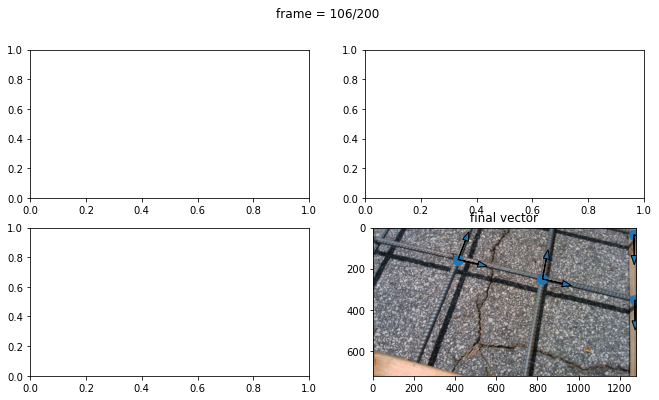

In [3]:
for a in range(0):
    pipe.wait_for_frames()

# get intrinsics
bag = rosbag.Bag(f'data/{bag_name}.bag')
count_loop = 0
for topic, msg, t in bag.read_messages():
    if 'Color_0/info/camera_info' in topic:
        K = msg.K
    count_loop +=1
    if count_loop > 20:
        break
bag.close()
K = np.array(K).reshape(3,3)
        
fig, axarr = plt.subplots(2,2,figsize=(11,6))
axarr = axarr.flatten()
total_frames = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


start_time = time.time()
with writer.saving(fig, f"results/{bag_name}.mp4", 100):
    for frame_idx in range(total_frames):
        start_readframe_time = time.time()
        # Store next frameset for later processing:
        frameset = pipe.wait_for_frames()
        color_frame = frameset.get_color_frame()
        depth_frame = frameset.get_depth_frame()


        # Cleanup:

        # visualize the capture frame
        color = np.asanyarray(color_frame.get_data())
        colorizer = rs.colorizer()
        colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
        H,W = color.shape[:2]
        gray = np.mean(colorized_depth,axis=2).astype(np.uint8)

        # align rgb and depth image
        align = rs.align(rs.stream.color)
        frameset = align.process(frameset)

        # Update color and depth frames:
        aligned_depth_frame = frameset.get_depth_frame()
        colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())
        depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
        depth = np.asanyarray(aligned_depth_frame.get_data())
        depth = depth*depth_scale
        end_readframe_time = time.time()


        intersections,vectors1,vectors2 = get_pose(color,depth,K)
#           start_plane_seg_time = time.time()
# #         intersections, vectors1, vectors2 = get_pose(color,depth,K)
#         # simple plane segmentation
#         start_projection_time = time.time()
#         xyz_full,rgb_full = rlc.project_rgbd2pcd(color,depth,K,dilation=100) # project to point cloud
#         end_projection_time = time.time()
        
#         idx = xyz_full[:,2]>0.001
#         xyz = xyz_full[idx,:]; rgb = rgb_full[idx,:]
# #         xyz = xyz[::30,:]; rgb = rgb[::30,:]   # *********dilation**********
#         xy = xyz[:,:2]; z=xyz[:,2]
#         start_linear_regression_time = time.time()
#         reg = linear_model.LinearRegression()
#         reg.fit(xy,z)
#         end_linear_regression_time = time.time()

#         class_binary = (z - (xy @ reg.coef_ + reg.intercept_) ) < -0.02
#         class_binary_full = (xyz_full[:,2] - (xyz_full[:,:2] @ reg.coef_ + reg.intercept_) ) < -0.02


#         xyz_top = xyz[class_binary,:]
#         rgb_top = rgb[class_binary,:]
#         xyz_top_full = xyz_full[class_binary_full,:]
#         rgb_top_full = rgb_full[class_binary_full,:]
        
# #         xyz_bottom = xyz[~class_binary,:]
# #         rgb_bottom = rgb[~class_binary,:]
        
#         start_backproj_time = time.time()
#         color_top, depth_top = rlc.project_pcd2rgb(xyz_top,rgb_top,H,W,K)
#         color_top_full, depth_top_full = rlc.project_pcd2rgb(xyz_top_full,rgb_top_full,H,W,K)

#         end_backproj_time = time.time()


#         # prepare for GMM
#         start_prepare_gmm_time = time.time()
        
#         ########################## parallels
#         y_idx = np.tile(np.expand_dims(np.arange(H),1),(1,W))
#         x_idx = np.tile(np.arange(W),(H,1))
#         end_prepare_gmm_time = time.time()
        
# #         print(x_idx)
# #         print(y_idx)
# #         raise

#         #################################
#         binary_depth = depth_top > 0.001
#         gmm_x = x_idx[binary_depth].reshape(-1)
#         gmm_y = y_idx[binary_depth].reshape(-1)
#         gmm_xy = np.c_[gmm_x,gmm_y] 
        
#         end_plane_seg_time = time.time()


#         # GMM prediction
#         rand_idx = np.random.rand(len(gmm_xy))<1.0 #  *dilation*
#         X = gmm_xy[rand_idx,:]
        
#         start_gmm_time = time.time()
#         X = torch.from_numpy(X).unsqueeze(0).to(torch.double).to(device)
#         my_gmm = mygmm.GMM_torch(n_components=20, max_iter=30)
#         my_gmm.fit(X)
#         my_gmm.filter_GMM(X,filter_ratio=4)
#         my_gmm.merge_GMM(X)
        
#         end_gmm_time = time.time()

#         # detect intersections
#         lines = []
# #         for i, (mean, covar) in enumerate(zip(dpgmm.means_,  dpgmm.covariances_)):
#         for i, (class_idx, mean, covar,angle,u,v) in enumerate(my_gmm.merge_list):
        
#             p2 = mean - torch.tensor([u[1],-u[0]])*v[1]
#             p3 = mean + torch.tensor([u[1],-u[0]])*v[1]  
#             lines.append((p2,p3))
        
#         # compute the poses
#         intersections = []
#         vectors1 = []
#         vectors2 = []
#         vectors3d_1 = []
#         vectors3d_2 = []
#         th_vec1_vec2 = []
#         for i in range(len(lines)):
#             for j in range(i+1,len(lines)):
#                 (x1,y1),(x2,y2) = lines[i]
#                 (x3,y3),(x4,y4) = lines[j]
#                 px = ((x1*y2-y1*x2)*(x3-x4) - (x1-x2)*(x3*y4-y3*x4)) / ((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4))
#                 py = ((x1*y2-y1*x2)*(y3-y4) - (y1-y2)*(x3*y4-y3*x4)) / ((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4))   
#                 thres = 30
#                 m1 = torch.arctan((y1-y2)/(x1-x2))
#                 m2 = torch.arctan((y3-y4)/(x3-x4))
#                 diff_m = min(abs(m1 - m2),np.pi-abs(m1-m2))
#                 if px < max(min(x1,x2),min(x3,x4))-thres or px > min(max(x1,x2),max(x3,x4))+thres:
#                     continue

#                 elif  diff_m < np.pi/2*0.75: # filter out the non-perpendicular pair
#                     continue

#                 else:
#                     # 2d space
#                     intersections.append([px,py])
#                     v1 = torch.tensor([x2-x1,y2-y1]); v1 = v1/torch.linalg.norm(v1)
#                     v2 = torch.tensor([x4-x3,y4-y3]); v2 = v2/torch.linalg.norm(v2)
#                     vectors1.append(v1); vectors2.append(v2)#;th_vec1_vec2.append(np.arccos(v1@v2))

# #                     # 3d space
# #                     u1_temp = np.linspace(x1,x2,num=100).astype(np.int)
# #                     v1_temp = np.linspace(y1,y2,num=100).astype(np.int)
# #                     u1 = u1_temp[(u1_temp<W)&(v1_temp<H)]; v1 = v1_temp[(u1_temp<W)&(v1_temp<H)]
# #                     d1 = depth_top[v1,u1]
# #                     xyz1 = rlc.project_pixel2pcd(u1,v1,d1,K)
# #                     xyz1 = xyz1[(xyz1[:,0]>0.001)|(xyz1[:,0]<-0.001),:]
# #                     x1 = xyz1[:,0];y1 = xyz1[:,1];z1 = xyz1[:,2];t1 = np.arange(len(x1)).reshape(-1,1)
# #                     if len(x1)>20:
# #                         if x1.max() - x1.min() > 0.02:
# #                             ransac = linear_model.RANSACRegressor();ransac.fit(t1, x1);kx1 = ransac.estimator_.coef_
# #                         else:
# #                             reg = LinearRegression().fit(t1, x1);kx1 = reg.coef_
# #                         if y1.max() - y1.min() > 0.02:
# #                             ransac = linear_model.RANSACRegressor();ransac.fit(t1, y1);ky1 = ransac.estimator_.coef_
# #                         else:
# #                             reg = LinearRegression().fit(t1, y1);ky1 = reg.coef_
# #                         if z1.max() - z1.min() > 0.02:
# #                             ransac = linear_model.RANSACRegressor();ransac.fit(t1, z1);kz1 = ransac.estimator_.coef_
# #                         else:
# #                             reg = LinearRegression().fit(t1, z1);kz1 = reg.coef_
# #                     elif len(x1)>1:
# #                         reg = LinearRegression().fit(t1, x1);kx1 = reg.coef_
# #                         reg = LinearRegression().fit(t1, y1);ky1 = reg.coef_
# #                         reg = LinearRegression().fit(t1, z1);kz1 = reg.coef_
# #                     else:
# #                         kx1=ky1=kz1=0
# #                     vector1 = np.array([kx1,ky1,kz1]); 
# #                     if kx1+ky1+kz1 == 0:
# #                         vector1 = np.array([0,0,0])
# #                     else:
# #                         vector1 = vector1/np.linalg.norm(vector1);
# #                     vectors3d_1.append(vector1)

# #                     u2_temp = np.linspace(x3,x4,num=100).astype(np.int)
# #                     v2_temp = np.linspace(y3,y4,num=100).astype(np.int)
# #                     u2 = u2_temp[(u2_temp<W)&(v2_temp<H)]; v2 = v2_temp[(u2_temp<W)&(v2_temp<H)]
# #                     d2 = depth_top[v2,u2]
# #                     xyz2 = rlc.project_pixel2pcd(u2,v2,d2,K)
# #                     xyz2 = xyz2[(xyz2[:,0]>0.001)|(xyz2[:,0]<-0.001),:]
# #                     x2 = xyz2[:,0];y2 = xyz2[:,1];z2 = xyz2[:,2];t2 = np.arange(len(x2)).reshape(-1,1)
# #                     if len(x2)>20:
# #                         if x2.max() - x2.min() > 0.02:
# #                             ransac = linear_model.RANSACRegressor();ransac.fit(t2, x2);kx2 = ransac.estimator_.coef_
# #                         else:
# #                             reg = LinearRegression().fit(t2, x2);kx2 = reg.coef_
# #                         if y2.max() - y2.min() >0.02:
# #                             ransac = linear_model.RANSACRegressor();ransac.fit(t2, y2);ky2 = ransac.estimator_.coef_
# #                         else:
# #                             reg = LinearRegression().fit(t2, y2);ky2 = reg.coef_
# #                         if z2.max() - z2.min() > 0.02:
# #                             ransac = linear_model.RANSACRegressor();ransac.fit(t2, z2);kz2 = ransac.estimator_.coef_
# #                         else:
# #                             reg = LinearRegression().fit(t2, z2);kz2 = reg.coef_                
# #                     elif len(x2)>1:
# #                         reg = LinearRegression().fit(t2, x2);kx2 = reg.coef_
# #                         reg = LinearRegression().fit(t2, y2);ky2 = reg.coef_
# #                         reg = LinearRegression().fit(t2, z2);kz2 = reg.coef_
# #                     else:
# #                         kx2=ky2=kz2=0
# #                     vector2 = np.array([kx2,ky2,kz2]); 
# #                     if kx2+ky2+kz2 == 0:
# #                         vector2 = np.array([0,0,0])
# #                     else:
# #                         vector2 = vector2/np.linalg.norm(vector2);
# #                     vectors3d_2.append(vector2)
#         intersections = torch.tensor(intersections)
# #         th_vec1_vec2 = torch.tensor(th_vec1_vec2)
# #         th_vec1_vec2[th_vec1_vec2>np.pi/2] = np.pi - th_vec1_vec2[th_vec1_vec2>np.pi/2]
        
# #         if th_vec1_vec2.max() - th_vec1_vec2.min()>15.0/180.0*np.pi:
# #             vector_idx = 
        
#         end_processing_time = time.time()
#         # visualize 
#         # 1 - filtered
#         axarr[0].clear()
#         axarr[0].imshow(color_top_full)
#         axarr[0].title.set_text('slicing out top layer')

#         # 2 - initial GMM
#         axarr[1].clear()
#         axarr[1].imshow(depth_top_full,cmap = "Greys")
#         my_gmm.plot_results(X,gmm_list='original',ax = axarr[1])
#         axarr[1].title.set_text('initial GMM')
#         axarr[1].invert_yaxis()


# #         3 - filter out fat
#         axarr[2].clear()
#         axarr[2].imshow(depth_top_full,cmap="Greys")
#         my_gmm.filter_GMM(X,filter_ratio=4) # change accordingly
#         my_gmm.merge_GMM(X)
#         my_gmm.filter_list = my_gmm.merge_list
#         my_gmm.plot_results(X,gmm_list='merge_list',ax = axarr[2])
#         axarr[2].invert_yaxis()
#         axarr[2].title.set_text('filter out fat GMM')

#         4 - generate pose
        axarr[3].clear()
        axarr[3].imshow(color)
        if len(intersections)!=0:
            intersections = np.array(intersections)
            axarr[3].scatter(intersections[:,0],intersections[:,1],100)
        for (px,py),(v1x,v1y),(v2x,v2y) in zip(intersections,vectors1,vectors2):
            vlength = 100
            if v1x<0:
                v1x = -v1x; v1y=-v1y
            if v2x<0:
                v2x = -v2x; v2y = -v2y
            axarr[3].arrow(px,py,vlength*v1x,vlength*v1y,head_width=30)
            axarr[3].arrow(px,py,vlength*v2x,vlength*v2y,head_width=30)       
            
        axarr[3].title.set_text('final vector')
        axarr[3].set_xlim(0,1280); axarr[3].set_ylim(0,720)
        axarr[3].invert_yaxis()

        fig.suptitle(f'frame = {frame_idx}/{total_frames}')
        writer.grab_frame()
        
        # progress bar
        clear_output(wait=True)
#         print(f"plane segmentation time = {end_plane_seg_time - start_plane_seg_time:.4f} s, GMM time = {end_gmm_time-start_gmm_time:.4f} s")
#         print(f"linear regression time = {end_linear_regression_time - start_linear_regression_time:.4f} s")
#         print(f"forward projection time = {end_projection_time-start_projection_time:.4f} s, back projection time = {end_backproj_time - start_backproj_time:.4f} s") 
#         print(f"prepare_gmm_time = {end_prepare_gmm_time - start_prepare_gmm_time:.4f} s")
#         print(f"readframe_time = {end_readframe_time-start_readframe_time:.4f} s")
        print(f"saving the {frame_idx}/{total_frames} frame")
        elapsed_time = time.time() - start_time
        bar_width= 80
        b = int(bar_width * frame_idx / total_frames)
        l = bar_width - b
        print(u"\u2588" * int(b) + '-' * int(l),f'{frame_idx/total_frames*100:.2f}%')
        print(f"elapsed time = {elapsed_time/60:.2f} min, time remain = {elapsed_time/(1+frame_idx)*(total_frames-frame_idx)/60:.2f} min")
        
        

In [5]:
Video(f"results/{bag_name}.mp4")